# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'I:\\OneDrive - SNU\\20 Grad work\\04 Forecast\\01 Code\\WeatherBench-master'

## Downloading the data

The data is hosted here. For this guide we will simply download the 500 hPa geopotential data (Z500).

In [3]:
# This might take a few minutes
# !wget "https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip" -O geopotential_500_5.625deg.zip

In [4]:
# download the data
import wget
dataserv = wget.download("https://dataserv.ub.tum.de/s/m1524895/download?path=%2F5.625deg%2Fgeopotential_500&files=geopotential_500_5.625deg.zip")
# https://pypi.org/project/wget/
# wget : get files from web

KeyboardInterrupt: 

In [3]:
import os
path_list = './geopotential_500'
#os.mkdir(path_list)

# !mkdir -p geopotential_500

In [30]:
# unzip
import zipfile
try:
    with zipfile.ZipFile("geopotential_500_5.625deg.zip") as zf:
        zf.extractall('geopotential_500')
        print("uncompress success")
except:
    print("uncompress fail")
    
# !unzip -d geopotential_500/ geopotential_500_5.625deg.zip

uncompress success


## Open the data

In [4]:
# open the *.nc format data 
z500 = xr.open_mfdataset('geopotential_500/*.nc', combine='by_coords')
#http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html
# error for Korean file / folder name

In [5]:
z500
# Coordinates : labels of longtitude, latitude, time
# Data Variables : z (z500) (whose each value has the labels of lon, lat, time)

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


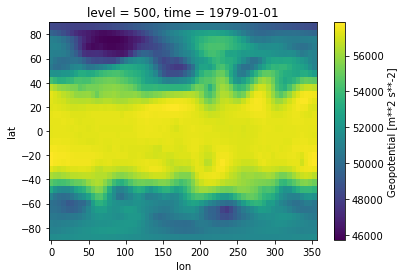

In [6]:
# Plot an example
z500.z.isel(time=0).plot();
# xarray.variable.isel(label=index) # select by index 

# cf.
# xarray[:, 0] # select by integer index 
# xarray.loc[:, 'IA'] # select by label name
# xarray.sel(space='IA') # select by label name
# xarray.isel(space=0) # select by integer index 

# xarray.plot()

## Create a simple climatological forecast

Remember that we are using the years 2017 and 2018 for testing/evaluation, so we are not allowed to use these years to train any data-driven model.

For more information on the climatology and persistence forecasts used in the paper check out `notebooks/1-climatology-persistence.ipynb`.

In [7]:
# To speed things up we will just take the mean for 2016
climatology = z500.sel(time=slice('2016', '2016')).mean('time').load()
# select by index 'time' from 2016-01-01 00:00:00 to 2016-12-31 23:00:00
# calculate mean by whole time (in 2016) -> then, we get blurly image

# .load() : load data into RAM. Unlike compute(), the original dataset is modified and returned.
# If we don't call load(), the dataset just exist as a dask array(not in memory)
# But, we can plot the dataset without calling load()

In [8]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 48765.18 48774.066 ... 51551.11 51558.305

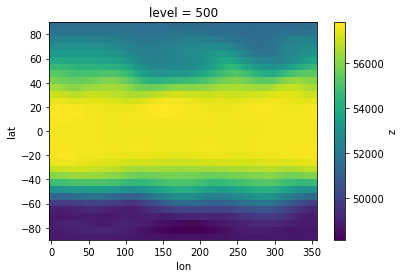

In [9]:
climatology.z.plot()

### Evaluate the climatology

Please check the paper for details on the evaluation metric. Here we will use the functions from `src/score.py`. To make sure we are always using the same targets for testing, we also implemented a function to load the test data.

In [10]:
from src.score import *

In [11]:
z500_test = load_test_data('geopotential_500/', 'z')[::12]  # Take data only every 12 hours to speed up computation on Binder

# load_test_data(path, z or t) : load z (geopotential) data by slicing from 2017 to 2018 (the range of test dataset)

# cf. 
# array[a:b:c] : start 'a' end 'b' every 'c' step
# array[::c] : end to end with every 'c' step

In [12]:
rmse_climatology = compute_weighted_rmse(climatology.z, z500_test).load()

# compute_weighted_rmse( forcast object: z, test target: z500_test )

In [13]:
rmse_climatology

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

In [14]:
# 왜 weight by latitude를 쓸까?
# weight를 쓰면 값에 차이가 있나? 
# 왜 본래 데이터에 weight를 하지 않고 rmse를 할 때 weight를 곱하나?

### RMSE without cosine weighting
da_fc = climatology.z.load()
da_true = z500_test.load()
error = da_fc - da_true

rmse1 = np.sqrt(((error)**2).mean()) 
rmse1 # 1269.5848

### RMSE with cosine weighting
da_fc = climatology.z.load()
da_true = z500_test.load()
error = da_fc - da_true

weights_lat = np.cos(np.deg2rad(error.lat))
weights_lat /= weights_lat.mean() # a/=b means a=a/b

rmse2 = np.sqrt(((error)**2 * weights_lat).mean(xr.ALL_DIMS))  
rmse2 # 1079.88382283

# RMSE without weights : 1269.5848
# RMSE with weights : 1079.88382283
# weight가 있으면 error가 줄어든다. 왜일까?

<xarray.DataArray ()>
array(1079.88382283)
Coordinates:
    level    int32 500

So we get a climatological RMSE of 1080 m^2/s^2 which is very similar to the RMSE we get for the climatology for all training years.

## Train a neural network

Now let's train a simple convolutional neural network. We are using several functions defined in `src/train_nn.py`. You can use and modify these or write your own function for data loading etc. 

For more information on the the networks, check out `notebooks/3-cnn-example.ipynb`.

In [15]:
from src.train_nn import * # import DataGenerator()

In [16]:
# This limits TF memory usage on the GPU
# limit_mem()

First, we need to create the data generators for training, validation and testing. The main reason why we are using data generators instead of just loading the data as Numpy arrays is that this would require loading the same data twice since the features and targets are the same fields, just offset in time. 

In [52]:
bs = 32 # batch_size
lead_time = 5*24 # the range of time for training data time right before validation data time. the unit is an hour (5 days * 24 hours)
var_dict = {'z': None} # the hyperparameter of DataGenerator function: define variable and it's level as dictionary type {'var': level}. 
# in this case, it means that load variable 'z(z500)' 
# if data is of single level, Use 'None' for level
# 'z' variable has only one level, z500. So, {'z': None}

In [137]:
# DataGenerator() : transpose Xarray data to Numpy array
# as the input, z500 has 4 coordinates
# lat: 32-d, lon: 64-d, time: 350640-d(1979-01-01 T00:00:00 to 2018-12-31 T23:00:00), level: 1-d (z고도500)
# as the output, numpy array X: (batch_size, 32, 64, 1), y: (batch_size, 32, 64, 1)

ds = z500
ds

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [109]:
ds['lat'] # able to call via coordinate name

<xarray.DataArray 'lat' (lat: 32)>
array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625, -53.4375,
       -47.8125, -42.1875, -36.5625, -30.9375, -25.3125, -19.6875, -14.0625,
        -8.4375,  -2.8125,   2.8125,   8.4375,  14.0625,  19.6875,  25.3125,
        30.9375,  36.5625,  42.1875,  47.8125,  53.4375,  59.0625,  64.6875,
        70.3125,  75.9375,  81.5625,  87.1875])
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19

In [125]:
ds['z'] # able to call via variable name

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [132]:
ds

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [1]:
from src.score import *
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Lambda, LeakyReLU
import tensorflow.keras.backend as K
from configargparse import ArgParser


batch_size = 32 
lead_time = 5*24 # ?????
var_dict = {'z': None} # {variable name : levels}. in this case, extract the values of any level from the 'z' variable

shuffle = True
load = False

ds = z500
data = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
#eg. generic_level = xr.DataArray(np.random.randn(2,3,1), dims=['lat', 'lon', 'time'], coords={'lat': [0,1], 'lon' : [0,1,2], 'time' : [1]})


for var, levels in var_dict.items():
    try:
        data.append(ds[var].sel(level=levels)) # dimension 'level'이 존재하면 data에 append
    except ValueError:
        data.append(ds[var].expand_dims({'level': generic_level}, axis=1)) # dimension 'level'이 존재하지 않으면 axis 추가
data ###############################

NameError: name 'z500' is not defined

In [ ]:

data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
data

In [ ]:

mean = data.mean(('time', 'lat', 'lon')).compute() 
std = data.std('time').mean(('lat', 'lon')).compute() 
# Normalize
data = (data - mean) / std
n_samples = data.isel(time=slice(0, -lead_time)).shape[0]
init_time = data.isel(time=slice(None, -lead_time)).time
valid_time = data.isel(time=slice(lead_time, None)).time


#Updates indexes after each epoch
def on_epoch_end():
    idxs = np.arange(n_samples)
    if shuffle == True:
        np.random.shuffle(idxs)
        
on_epoch_end()


# For some weird reason calling .load() earlier messes up the mean and std computations
if load: 
    print('Loading data into RAM'); 
    data.load()


#Denotes the number of batches per epoch
int(np.ceil(n_samples / batch_size)) # batch 개수

#Generate one batch of data
idxs = idxs[i * batch_size:(i + 1) * batch_size]
X = data.isel(time=idxs).values
y = data.isel(time=idxs + lead_time).values

X, y

In [146]:
data

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64, 1)","(8784, 32, 64, 1)"
Count,322 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [153]:
# DataGenerator() : transpose Xarray data to Numpy array

# Use 2015 for training and 2016 for validation
dg_train = DataGenerator( 
    z500.sel(time=slice('2015', '2015')), var_dict, lead_time, batch_size=bs, load=True) # load=True : load data into RAM
# do we need to shuffle for time series data?
# yes. because the time series is not stationary, so contiguous data is likely to be highly correlated.
# no. the data is not being randomly shuffled before splitting. This is for two reasons.
# chopping the data is still possible after splited windows of consecutive samples.
# the validation/test results are more realistic, being evaluated on data collected after the model was trained.
dg_valid = DataGenerator(
    z500.sel(time=slice('2016', '2016')), var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)
# mean, std are used to normalize data
# mean: If None, compute mean from data. 전체 시간, 위치를 통틀어 평균 (so, squeeze 3 axis - lon, lat, time)
# std: If None, compute standard deviation from data. 전 지구의 시간별 std (squeeze 2 axis - lon, lat)

Loading data into RAM
Loading data into RAM


In [51]:
# Now also a generator for testing. Important: Shuffle must be False!
dg_test = DataGenerator(z500.sel(time=slice('2017', '2018')), # Limiting the data for Binder, slice=(start=0, end=the end, step=12)
                        var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [57]:
X

array([[[[-4.827081  ],
         [-4.875397  ],
         [-4.909907  ],
         ...,
         [-4.716643  ],
         [-4.744256  ],
         [-4.7856755 ]],

        [[-4.847784  ],
         [-4.923713  ],
         [-5.013435  ],
         ...,
         [-4.716643  ],
         [-4.7097464 ],
         [-4.764955  ]],

        [[-5.241208  ],
         [-5.1307836 ],
         [-5.013435  ],
         ...,
         [-4.827074  ],
         [-5.1997952 ],
         [-5.2964344 ]],

        ...,

        [[-0.5615129 ],
         [-0.68575794],
         [-0.80309266],
         ...,
         [-0.5270035 ],
         [-0.4924941 ],
         [-0.49940443]],

        [[-0.37515938],
         [-0.38896596],
         [-0.4165791 ],
         ...,
         [-0.5477239 ],
         [-0.44418168],
         [-0.38896596]],

        [[-0.8652152 ],
         [-0.8445124 ],
         [-0.82380956],
         ...,
         [-0.9273377 ],
         [-0.9066349 ],
         [-0.885918  ]]],


       [[[-4.268007  ],


In [58]:
y

array([[[[-5.6208396 ],
         [-5.6139293 ],
         [-5.6139293 ],
         ...,
         [-5.710561  ],
         [-5.6691556 ],
         [-5.6415424 ]],

        [[-5.6415424 ],
         [-5.6691556 ],
         [-5.703665  ],
         ...,
         [-5.6691556 ],
         [-5.634646  ],
         [-5.6277356 ]],

        [[-5.807193  ],
         [-5.703665  ],
         [-5.6139293 ],
         ...,
         [-6.393884  ],
         [-6.20062   ],
         [-5.986654  ]],

        ...,

        [[-0.8652152 ],
         [-0.885918  ],
         [-0.8997246 ],
         ...,
         [-0.43036807],
         [-0.6374385 ],
         [-0.80308914]],

        [[-0.34754625],
         [-0.4510885 ],
         [-0.54081005],
         ...,
         [-0.08526365],
         [-0.16808549],
         [-0.25091082]],

        [[ 0.40479213],
         [ 0.39098558],
         [ 0.377179  ],
         ...,
         [ 0.44619778],
         [ 0.4323912 ],
         [ 0.4185987 ]]],


       [[[-4.9513264 ],


In [43]:
X, y = dg_train[0]

In [44]:
X, y

(array([[[[-4.827081  ],
          [-4.875397  ],
          [-4.909907  ],
          ...,
          [-4.716643  ],
          [-4.744256  ],
          [-4.7856755 ]],
 
         [[-4.847784  ],
          [-4.923713  ],
          [-5.013435  ],
          ...,
          [-4.716643  ],
          [-4.7097464 ],
          [-4.764955  ]],
 
         [[-5.241208  ],
          [-5.1307836 ],
          [-5.013435  ],
          ...,
          [-4.827074  ],
          [-5.1997952 ],
          [-5.2964344 ]],
 
         ...,
 
         [[-0.5615129 ],
          [-0.68575794],
          [-0.80309266],
          ...,
          [-0.5270035 ],
          [-0.4924941 ],
          [-0.49940443]],
 
         [[-0.37515938],
          [-0.38896596],
          [-0.4165791 ],
          ...,
          [-0.5477239 ],
          [-0.44418168],
          [-0.38896596]],
 
         [[-0.8652152 ],
          [-0.8445124 ],
          [-0.82380956],
          ...,
          [-0.9273377 ],
          [-0.9066349 ],
    

In [49]:
# Batches have dimensions [batch_size, lat, lon, channels]
X.shape, y.shape

# 32-D latitude, 64-D longitude, channel=1

((32, 32, 64, 1), (32, 32, 64, 1))

Now let's build a simple fully convolutional network. We are using periodic convolutions in the longitude direction. These are defined in `train_nn.py`.

In [46]:
# simple fully convolutional network

cnn = keras.models.Sequential([
    PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)), # in the input_shape, except batch dimension
    PeriodicConv2D(filters=1, kernel_size=5) # input format information is only needed at the first layer
])

### the another coding method (equivalent above) ###
'''
# create model
cnn = Sequential()

# add model layers
cnn.add(PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)))
cnn.add(PeriodicConv2D(filters=1, kernel_size=5))
'''

"\n# create model\ncnn = Sequential()\n\n# add model layers\ncnn.add(PeriodicConv2D(filters=32, kernel_size=5, conv_kwargs={'activation':'relu'}, input_shape=(32, 64, 1,)))\ncnn.add(PeriodicConv2D(filters=1, kernel_size=5))\n"

In [51]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
periodic_conv2d_14 (Periodic (None, 32, 64, 32)        832       
_________________________________________________________________
periodic_conv2d_15 (Periodic (None, 32, 64, 1)         801       
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [47]:
# For a mean squared error regression problem
cnn.compile(keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

### the another coding method (equivalent above) ###
cnn.compile(optimizer = 'Adam',
           loss='mse')

In [48]:
# Train a little bit ;)
cnn.fit(dg_train, epochs=1, validation_data=dg_valid)

270/270 [==============================] - 38s 139ms/step - loss: 1.0812 - val_loss: 0.8260


### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [26]:
preds = create_predictions(cnn, dg_test)
# create_predictions(model, test dataset)
# create_predictions() : generate the prediction. then, Unnormalize and collect the predicted data into xarray
# preds = preds * dg_test.std.values + dg_test.mean.values  # Unnormalize

Instructions for updating:
Please use Model.predict, which supports generators.


In [27]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 1340)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-02 ... 2018-12-31T12:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 50725.863 50771.074 ... 51247.727

In [28]:
compute_weighted_rmse(preds.z, z500_test).load()
# 923.90897686


### RMSE without cosine weighting
error = preds.z - z500_test

rmse3 = np.sqrt(((error)**2).mean()) 
rmse3 # 1462.5831

<xarray.DataArray 'z' ()>
array(1399.1425, dtype=float32)

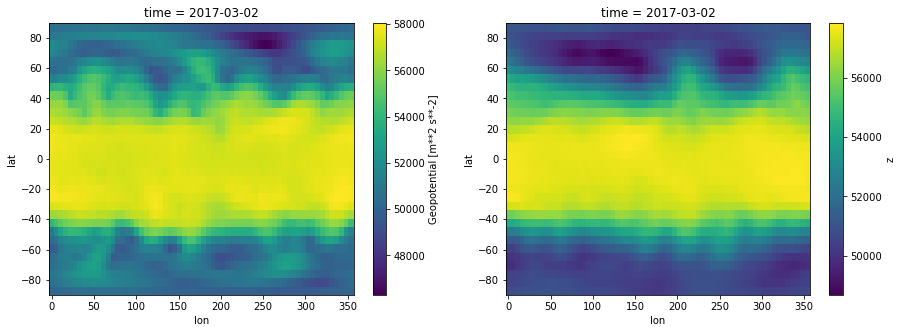

In [29]:
time = '2017-03-02T00'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
p1= z500_test.sel(time=time).plot(ax=ax1) # ground truth
p2= preds.sel(time=time).z.plot(ax=ax2); # prediction

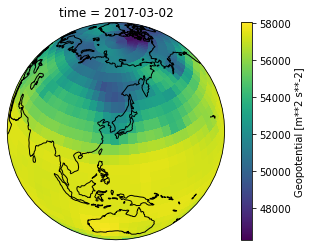

In [30]:
import cartopy.crs as ccrs

time = '2017-03-02T00'
p1= z500_test.sel(time=time).plot(subplot_kws=dict(projection=ccrs.Orthographic(130, 35), facecolor="gray"),
                                  transform = ccrs.PlateCarree(),
                                 ) # ground truth

p1.axes.set_global()
p1.axes.coastlines()

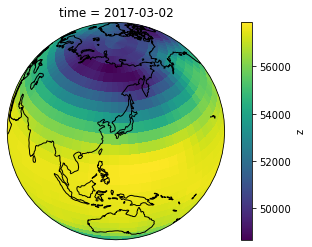

In [31]:
time = '2017-03-02T00'
p2= preds.sel(time=time).z.plot(subplot_kws=dict(projection=ccrs.Orthographic(130, 35), facecolor="gray"),
                                  transform = ccrs.PlateCarree(),
                                 ); # prediction
p2.axes.set_global()
p2.axes.coastlines()